#**~ PREDIKSI LONGSOR DENGAN INTEGRASI DATA LINGKUNGAN & MACHINE LEARNING PIPELINE ~**
By : Farras Fadhilah (2106723565)

##**1. PENDAHULUAN**

Berdasarkan hasil review dan modifikasi pada contoh scipt, saya menggunakan data spasial untuk melakukan prediksi tanah longsor menggunakan integrasi data lingkungan dan *machine learning pipeline*. Berikut adalah tahapannya:

##**2. PERSIAPAN**

###`Library Installation`



In [ ]:
pip install geopandas

In [ ]:
pip install pyspatialml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 52.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 58.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 7.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.2
    Uninstalling numpy-1.25.2:
      Successfully uninstalled numpy-1.25.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.4
    Uninstalling scipy-1.11.4:
      Successfully uninstalled scipy-1.11.4
  Attempting uninstall: pandas
    Found existing install

Setelah instalasi, masuk ke file berikut:
1. "/usr/local/lib/python3.10/dist-packages/pyspatialml/raster.py". Open the files by double click, Line 2563 of raster.py need be edited. `From`: pixel_indices = np.zeros(0, dtype=np.int) -> `To`: pixel_indices = np.zeros(0, dtype=np.int_) -> to save the change **Ctrl+s**


2. "/usr/local/lib/python3.10/dist-packages/pyspatialml/transformers.py". Open the files by double click, Line 213 of transformers.py need be edited. `From`: mask = np.zeros(neighbor_dist.shape, dtype=np.bool) -> `To`: mask = np.zeros(neighbor_dist.shape, dtype=np.bool_) -> to save the change **Ctrl+s**

### `Import`

In [ ]:
from copy import deepcopy
from tempfile import NamedTemporaryFile
from pyspatialml import Raster
from pyspatialml.preprocessing import xy_coordinates, distance_to_corners
import pyspatialml.datasets.meuse as ms
from pyspatialml.raster import reproject
import pyspatialml as psl

import numpy as np
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame
from shapely.geometry import Point

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap

import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_validate, KFold
from sklearn.model_selection import GridSearchCV

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7e138ba3fbe0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 1175, in _make_controller_from_path
    lib_controller = controller_class(
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/usr/lib/python3.10/ctypes/__init__.py", line 374, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: /usr/local/lib/python3.10/dist-packages/numpy.libs/libopenblas64_p-r0-5007b62f.3.23.dev.so: cannot open shared object file: No such file or directory


### `Setting Environment`

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir("drive/MyDrive/KokusB/06_MachineLearningPipeline/parameter")

In [ ]:
os.getcwd()

'/content/drive/MyDrive/KokusB/06_MachineLearningPipeline/parameter'

### `Load Data`

`Data Parameter Lingkungan` : Parameters.tif

`Data Kejadian Longsor` : Titik_Training.shp

In [ ]:
# Membuat variabel dari data yang dipanggil
parametertif = 'Parameters.tif' # Predictor
training_file = 'Titik_Training.shp' # Target

In [ ]:
# Membuat objek stack yang mewakili data raster
stack = Raster(parametertif)
stack.names

dict_keys(['Parameters_1', 'Parameters_2', 'Parameters_3', 'Parameters_4', 'Parameters_5', 'Parameters_6', 'Parameters_7', 'Parameters_8', 'Parameters_9', 'Parameters_10', 'Parameters_11', 'Parameters_12'])

In [ ]:
# Cek sistem koordinat/proyeksi
crstif = stack.crs
print("CRS dari data raster:", crstif)

CRS dari data raster: EPSG:4326


In [ ]:
stack.names = ('aspect', 'elevation', 'landuse', 'litologi', 'ndbi', 'ndvi', 'rain',  'river', 'road',  'slope',  'structure',  'soil')

In [ ]:
# Baca file shapefile sebagai GeoDataFrame
gdf = gpd.read_file(training_file)

# Mengubah sistem koordinat menjadi EPSG:4326 agar sama dengan data raster
gdf = gdf.to_crs(epsg=4326)
gdf['Class'] = gdf['Class'].astype(float)

# Simpan kembali sebagai shapefile
gdf.to_file('titik_output.shp')

# Panggil kembali
training_pts_file = 'titik_output.shp'

<ipython-input-14-668c94f70475>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn-ticks')


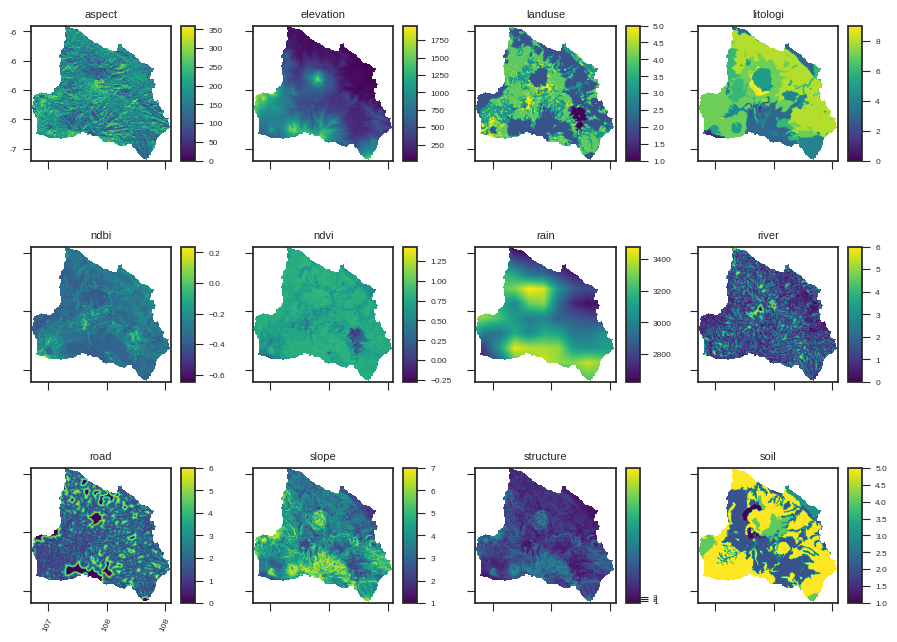

In [ ]:
# Plot prediktor (Layer raster)
mpl.style.use('seaborn-ticks')
axs = stack.plot(figsize=(9, 7))
ax = axs.flatten()[10]
im = ax.images
im[0].colorbar.set_ticks([1,2,3])
ax = axs.flatten()[8]
ax.tick_params(axis='x', labelrotation=65)

plt.tight_layout()
plt.show()

### `Spatial Information`

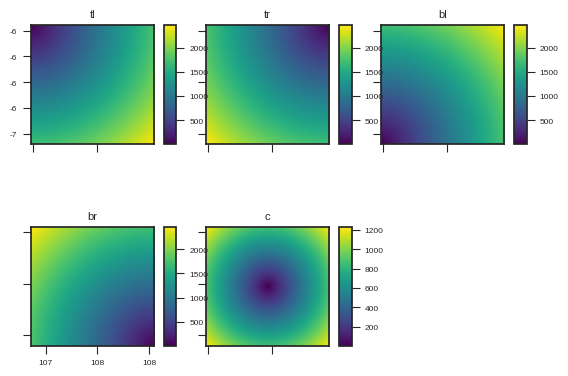

In [ ]:
# Membuat grid koordinat
xy_layer = xy_coordinates(
    layer=stack.iloc[0],
    file_path=NamedTemporaryFile(suffix=".tif").name
)

edms = distance_to_corners(
    layer=stack.iloc[0],
    file_path=NamedTemporaryFile(suffix=".tif").name
)
edms.rename(
    {old: new for (old, new) in zip(edms.names, ["tl", "tr", "bl", "br", "c"])},
    in_place=True
)

edms.plot()
plt.show()

In [ ]:
# Menambahkanya dengan objek stack
stack = stack.append([xy_layer, edms])

<ipython-input-17-7f2447a1b104>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn-ticks')


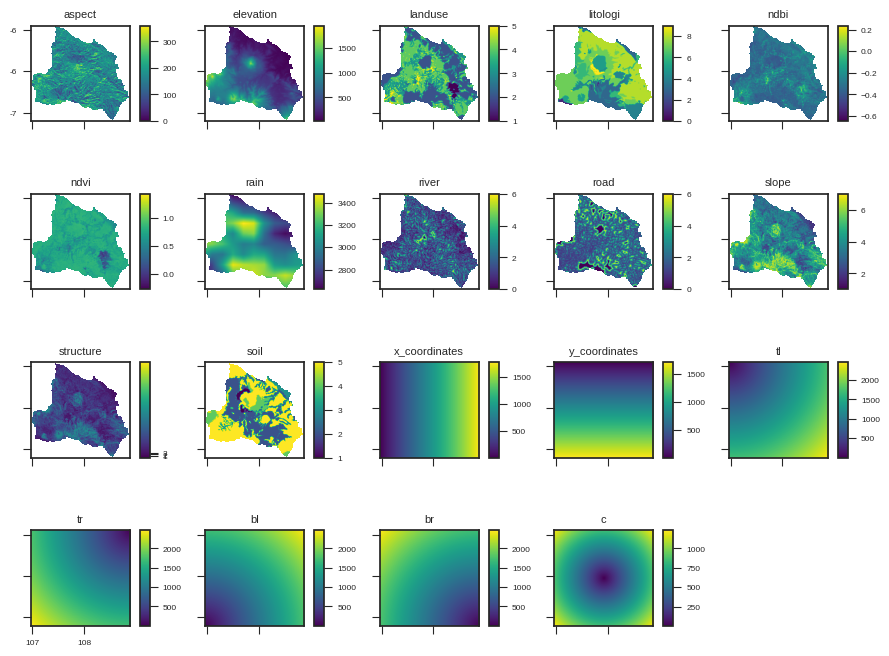

In [ ]:
# Plot prediktor baru
mpl.style.use('seaborn-ticks')
axs = stack.plot(figsize=(9, 7))
ax = axs.flatten()[10]
im = ax.images
im[0].colorbar.set_ticks([1,2,3])
ax = axs.flatten()[8]
ax.tick_params(axis='x', labelrotation=65)

plt.tight_layout()
plt.show()

In [ ]:
# Melakukan intersect dengan object stack
stack = stack.intersect()

<ipython-input-19-33e5f8bbb629>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn-ticks')


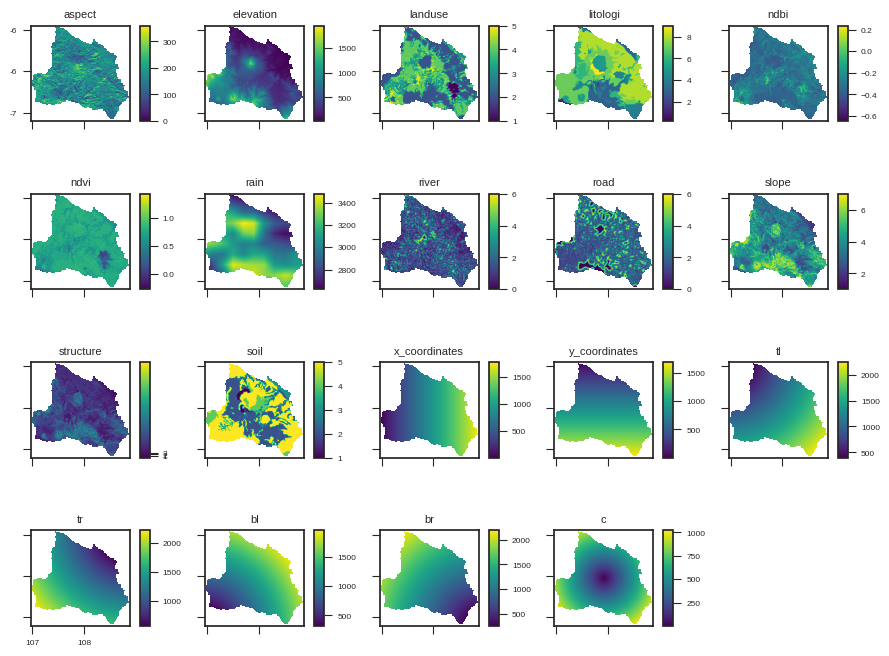

In [ ]:
# Hasil plot prediktor
mpl.style.use('seaborn-ticks')
axs = stack.plot(figsize=(9, 7))
ax = axs.flatten()[10]
im = ax.images
im[0].colorbar.set_ticks([1,2,3])
ax = axs.flatten()[8]
ax.tick_params(axis='x', labelrotation=65)

plt.tight_layout()
plt.show()

In [ ]:
stack

Raster Object Containing 19 Layers
    attribute                                             values
0       names  [aspect, elevation, landuse, litologi, ndbi, n...
1       files  [/tmp/tmp456imqn5.tif, /tmp/tmp456imqn5.tif, /...
2        rows                                               1710
3        cols                                               1777
4         res     (0.0002694945852357842, 0.0002694945852358479)
5  nodatavals  [-3.4028234663852886e+38, -3.4028234663852886e...


##**3. PREPROCESSING DATA**

###`Data SHP`

In [ ]:
# Membaca data
training_pts = gpd.read_file(training_pts_file)
training_pts.head()

,Kemiringan,Tanah,frek,Bahaya,tahun,penyebab,korban,Kerugian,Mitigasi,waktu,Keterangan,GlobalID,CreationDa,EditDate,Name,ORIG_FID,Class,Sumber,geometry
0,10.0,1,0,2,2023-11-08,Hujan,2,Rumah rusak ringan,Penanaman pohon,1899-12-30,None,{485A2CEB-AF83-49C5-A5DD-918B6A3CEFA7},2023-11-08,2023-11-08,None,0,1.0,Survey Lapangan,POINT (107.95278 -6.91355)
1,67.2,1,2,2,2022-12-15,hujan,0,None,None,1899-12-30,None,{389DAF69-C48E-42C9-939D-5CE244078671},2023-11-09,2023-11-09,None,0,1.0,Survey Lapangan,POINT (107.87309 -6.86775)
2,90.0,0,0,1,2023-10-27,rembesan saluran ditambah hujan,0,None,None,1899-12-30,None,{AF1DC238-2687-4519-9871-3249F1D6B76D},2023-11-09,2023-11-09,None,0,1.0,Survey Lapangan,POINT (107.87373 -6.86876)
3,80.0,0,0,2,2022-12-14,hujan,0,None,None,1899-12-30,None,{1CCA6D6C-7410-4F68-AF33-1E41436289CB},2023-11-09,2023-11-09,None,0,1.0,Survey Lapangan,POINT (107.87339 -6.86821)
4,80.0,1,0,2,2016-02-09,"hujan besar, sumber air tabrakan jadi deres ke...",0,3 rumah tertimpa,None,2023-11-09,None,{0A8F9B49-1E72-47AA-8266-F56E88F20ECC},2023-11-09,2023-11-10,None,0,1.0,Survey Lapangan,POINT (107.87533 -6.86782)


In [ ]:
print(training_pts.dtypes)

Kemiringan     float64
Tanah           object
frek             int64
Bahaya          object
tahun           object
penyebab        object
korban           int64
Kerugian        object
Mitigasi        object
waktu           object
Keterangan      object
GlobalID        object
CreationDa      object
EditDate        object
Name            object
ORIG_FID         int64
Class          float64
Sumber          object
geometry      geometry
dtype: object


In [ ]:
# Cek proyeksi kembali
crs = training_pts.crs
print("CRS dari data shapefile:", crs)

CRS dari data shapefile: EPSG:4326


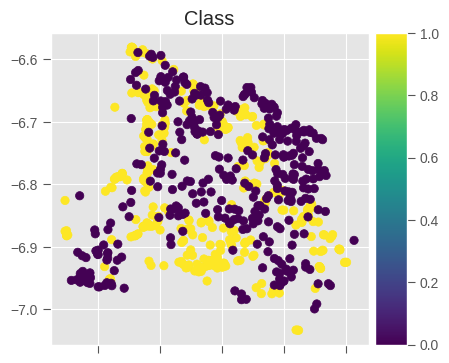

In [ ]:
# Plotting data training
from mpl_toolkits.axes_grid1 import make_axes_locatable
mpl.style.use('ggplot')

fig, axs = plt.subplots(2, figsize=(8.5, 7))

for i, (ax, target) in enumerate(zip(axs.ravel(), ['Class'])):
    ax.set_title(target.title())
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="10%", pad=0.05)
    training_pts.plot(column=target, legend=True, ax=ax, cax=cax, cmap='viridis')

    if i != 0:
        ax.set_yticklabels([])

    if i != 3:
        ax.set_xticklabels([])
    else:
        ax.tick_params(axis='x', labelrotation=65)

fig.delaxes(axs.flatten()[i+1])
plt.tight_layout()
plt.show()

### `Data Raster`

In [ ]:
# Ekstrak raster untuk nilai parameter
training_df = stack.extract_vector(gdf=training_pts)

training_df.index = training_df.index.get_level_values("geometry_idx")
training_df = training_df.merge(
    training_pts.loc[:, ("Class")],
    left_index=True,
    right_index=True
)

# Cleaning missing values
training_df = training_df.dropna()
training_df.head()

,aspect,elevation,landuse,litologi,ndbi,ndvi,rain,river,road,slope,...,soil,x_coordinates,y_coordinates,tl,tr,bl,br,c,geometry,Class
geometry_idx,,,,,,,,,,,,,,,,,,,,,
0,155.699265,651.636414,2.0,3.444944,-0.068751,0.438676,3311.269775,0.0,1.0,2.773309,...,2.0,785.0,1237.0,1465.057617,1585.007935,915.974365,1097.663452,395.642517,POINT (107.95278 -6.91355),1.0
1,235.284073,589.224487,2.0,4.000000,-0.097412,0.547178,3132.282959,1.0,1.0,6.000000,...,5.0,490.0,1068.0,1175.042114,1671.651855,806.833923,1436.898438,451.412231,POINT (107.87309 -6.86775),1.0
2,257.327271,582.997803,3.0,4.000000,-0.339969,0.733428,3134.640625,1.0,1.0,4.000000,...,2.0,492.0,1071.0,1178.603027,1672.033813,805.672363,1433.771240,451.078705,POINT (107.87373 -6.86876),1.0
3,224.418045,587.878906,3.0,4.000000,-0.091308,0.553150,3133.313721,1.0,1.0,5.000000,...,2.0,491.0,1069.0,1176.368164,1671.522095,806.648010,1435.557373,451.004425,POINT (107.87339 -6.86821),1.0
4,301.376007,584.988953,2.0,4.000000,-0.231942,0.679486,3136.713867,2.0,1.0,6.084273,...,5.0,498.0,1068.0,1178.400635,1665.505371,811.717285,1429.743042,444.374847,POINT (107.87533 -6.86782),1.0


In [ ]:
# Mengetahui jumlah baris dan nama kolom
print("Jumlah baris dalam data:", stack.shape[0])
print(training_df.columns)

Jumlah baris dalam data: 1710
Index(['aspect', 'elevation', 'landuse', 'litologi', 'ndbi', 'ndvi', 'rain',
       'river', 'road', 'slope', 'structure', 'soil', 'x_coordinates',
       'y_coordinates', 'tl', 'tr', 'bl', 'br', 'c', 'geometry', 'Class'],
      dtype='object')


## **4. MODEL  PREDIKSI DENGAN MACHINE LEARNING**

###`ML Pipeline`

In [ ]:
stack.names

dict_keys(['aspect', 'elevation', 'landuse', 'litologi', 'ndbi', 'ndvi', 'rain', 'river', 'road', 'slope', 'structure', 'soil', 'x_coordinates', 'y_coordinates', 'tl', 'tr', 'bl', 'br', 'c'])

In [ ]:
# Membuat Machine Learning
longsor_idx = [i for i, name in enumerate(stack.names) if name == 'Class']

trans = ColumnTransformer([
    ('ohe', OneHotEncoder(categories='auto', handle_unknown='ignore'), longsor_idx)
    ], remainder='passthrough')
# Model Selection : Random
rf = RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=1234)
rf = Pipeline([
    ('preproc', trans),
    ('regressor', rf)])

In [ ]:
# Memisahkan variabel response/target (y: dependent) dengan variabel prediktor (x: independent)
X = training_df.loc[:, stack.names]
y = training_df.loc[:, ['Class']]
rf.fit(X, y)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/compose/_column_transformer.py:1624: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as a different type depending on the ColumnTransformer inputs.
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  [])])),
                ('regressor',
                 RandomForestRegressor(n_estimators=500, n_jobs=-1,
                                       random_state=1234))])

###`Validation - Evaluasi Model`

In [ ]:
# Cross-validation untuk evaluasi model
outer = KFold(n_splits=10, shuffle=True, random_state=1234)
scores = cross_validate(rf, X, y, scoring='neg_mean_squared_error', cv=10, n_jobs=1)
rmse = np.sqrt(-scores['test_score']).mean()

print("Our RMSE score is {}".format(rmse))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example usi

Our RMSE score is 0.32199752727893644


##**5. ANALISIS DAN INTERPRETASI HASIL**

###`Feature Importances`

In [ ]:
ohe_names = deepcopy(list(stack.names))
if longsor_idx:
    ohe_names.insert(longsor_idx[0], 'Class1')
ohe_names = np.array(ohe_names)

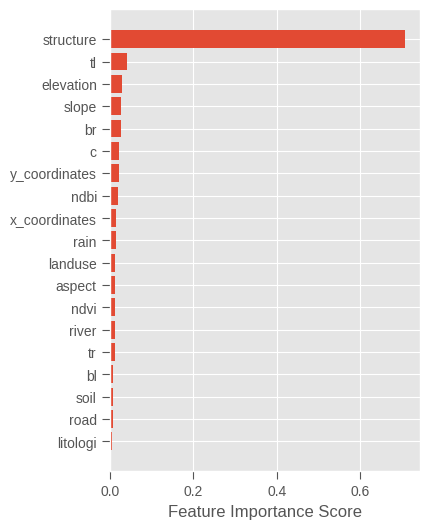

In [ ]:
mpl.style.use('ggplot')

fimp = rf.named_steps['regressor'].feature_importances_

fig, ax = plt.subplots(figsize=(4, 6))
ax.barh(y=ohe_names[fimp.argsort()], width=fimp[fimp.argsort()])
ax.set_xlabel('Feature Importance Score')
plt.show()

###`Visualisasi`

In [ ]:
preds = stack.predict(rf)
preds.rename(
    {old: new for old, new in zip(preds.names, ['Prediksi_Longsor'])},
    in_place=True
)
preds.Prediksi_Longsor.cmap = 'rainbow'

<ipython-input-34-01ccc443ac74>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn-ticks')
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:718: RuntimeWarning: overflow encountered in multiply
  The data value(s) to convert to RGBA.


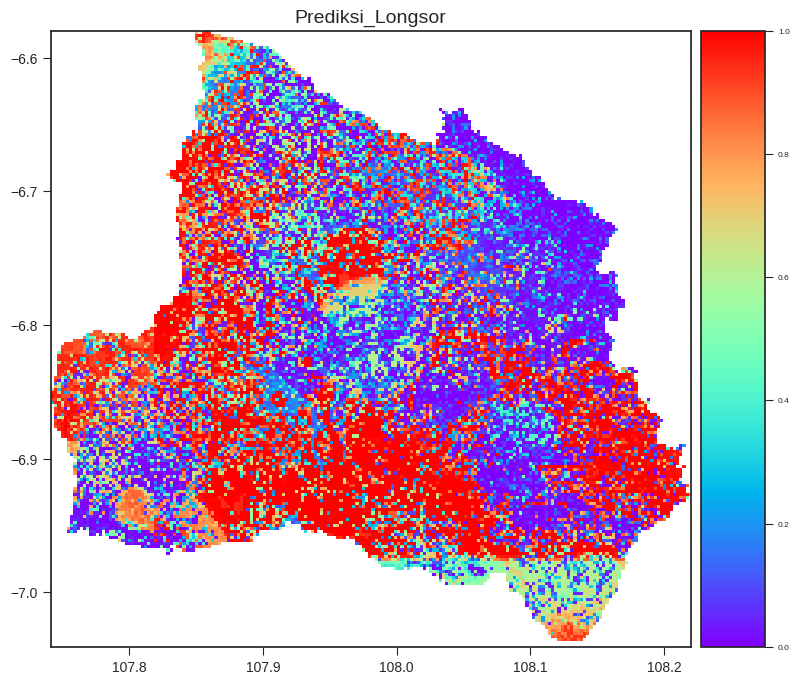

In [ ]:
mpl.style.use('seaborn-ticks')
preds.plot(out_shape=(200, 200), title_fontsize=14, figsize=(10, 8))
plt.show()